In [ ]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

In [ ]:
from qwenimage.datamodels import QwenConfig
from qwenimage.finetuner import QwenLoraFinetuner
from qwenimage.foundation import QwenImageFoundation, QwenImageRegressionFoundation

foundation = QwenImageFoundation(QwenConfig(
    vae_image_size=1024 * 1024,
    regression_base_pipe_steps=4,
))

In [ ]:
finetuner = QwenLoraFinetuner(foundation, foundation.config)
finetuner.load("/data/reg-mse-pixel-lpips_005000", lora_rank=32)

In [ ]:
from qwenimage.experiments.experiments_qwen import PipeInputs

pipe_inputs = PipeInputs()
pipe_inputs[0]
from qwenimage.datamodels import QwenInputs

idx = 0
inps = QwenInputs(**pipe_inputs[idx])
inps.num_inference_steps = 4
inps.vae_image_override = 1024 * 1024
inps.latent_size_override = 1024 * 1024
finetuner.enable()
foundation.scheduler.config["base_shift"] = 2.5
foundation.scheduler.config["max_shift"] = 2.5
outs = foundation.base_pipe(inps)
outs[0]

In [ ]:
from qwenimage.sources import EditingSource


src = EditingSource(
    data_dir="/data/CrispEdit",
    total_per=10,
)

image=[<PIL.Image.Image image mode=RGB size=720x960 at 0x79B38784A4D0>] prompt='Remove the furniture and show an completely empty room interior' height=None width=None negative_prompt=None true_cfg_scale=1.0 num_inference_steps=2 generator=<torch._C.Generator object at 0x79b38750fe30> max_sequence_length=512 vae_image_override=1048576 latent_size_override=1048576
Time taken by QwenImageFoundation.offload_text_encoder: 2.293149009346962e-06 seconds
Time taken by Preprocessing: 0.03936042613349855 seconds
_get_qwen_prompt_embeds, image
[<PIL.Image.Image image mode=RGB size=320x448 at 0x79B3875C3730>]
{'input_ids': tensor([[151644,   8948,    198,  74785,    279,   1376,   4419,    315,    279,
           1946,   2168,    320,   3423,     11,   6083,     11,   1379,     11,
          10434,     11,   6171,     11,   4004,    701,   1221,  10339,   1246,
            279,   1196,    594,   1467,   7600,   1265,  11596,    476,   5602,
            279,   2168,     13,  19813,    264,    501,

_encode_vae_image, image_latents
Shape: (1, 16, 1, 148, 112)
Min: -1.7578125, Max: 1.921875, Mean: -0.058349609375
Device: cuda:0, Dtype: torch.bfloat16, Requires Grad: False
Time taken by QwenImageEditPlusPipeline._encode_vae_image: 0.07727885595522821 seconds
tensor([1.0000, 0.9526, 0.0000], device='cuda:0')
Time taken by Prep gen: 0.08572582388296723 seconds


  0%|          | 0/2 [00:00<?, ?it/s]

Time taken by loop 0: 0.49718725914135575 seconds
Time taken by loop 1: 0.5139311410021037 seconds
Time taken by loop: 1.0241571480873972 seconds
Time taken by pre decode: 0.03755589993670583 seconds
Time taken by vae.decode: 0.07436265400610864 seconds
Time taken by post process: 0.1024206189904362 seconds
Time taken by offload: 0.020022688200697303 seconds
Time taken by QwenImageEditPlusPipeline.__call__: 1.4749357928521931 seconds


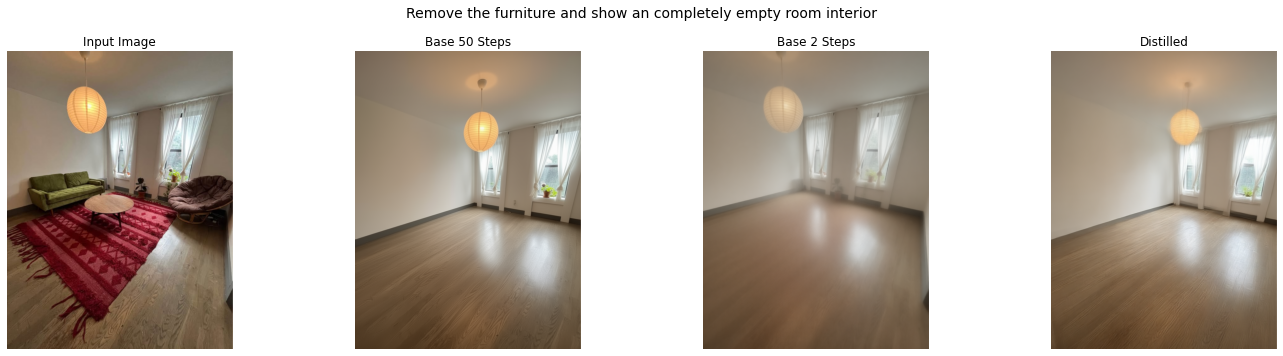

In [ ]:
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import torch

from qwenimage.datamodels import QwenInputs

# idx = 15_105
# text, _, image = src[idx]
# print(text)

inps = QwenInputs(
    # prompt="Turn the man into a goblin",
    # image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/media_images_sample_images_34141_02388e50bbd59c3efb75.png")],
    
    # prompt="Turn the background into a deep forest",
    # image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/media_images_sample_images_34141_02388e50bbd59c3efb75.png")],
    
    # prompt="Add a large hot air balloon to the center of the scene",
    # image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/wand-3270.png")],
    
    # prompt="Remove the little girl",
    # image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/test_images_v1/test_image_1.jpg")],
    
    # prompt="Turn the corn into two peaches, one on each hand",
    # image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/test_images_v1/test_image_5.jpg")],
    
    # prompt="Colorize the sketch to a painting of a forest",
    # image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/hK1XxQ0li9QS9AlhZitJI.jpeg")],
    
    prompt="Remove the furniture and show an completely empty room interior",
    image=[load_image("/home/ubuntu/Qwen-Image-Edit-Angles/scripts/assets/471419729_122147939600372575_2367375612828096747_n.jpg")],
    num_inference_steps = 2,
    vae_image_override = 1024 * 1024,
    latent_size_override = 1024 * 1024,
)

finetuner.enable()
foundation.scheduler.config["base_shift"] = 2.0
foundation.scheduler.config["max_shift"] = 2.0
inps.generator = torch.Generator().manual_seed(67)
outs_distill = foundation.base_pipe(inps)

finetuner.disable()
foundation.scheduler.config["base_shift"] = 0.5
foundation.scheduler.config["max_shift"] = 0.9
inps.generator = torch.Generator().manual_seed(67)
outs_base_2step = foundation.base_pipe(inps)

inps.num_inference_steps = 50
inps.generator = torch.Generator().manual_seed(67)
outs_base_50step = foundation.base_pipe(inps)



fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot input image
axes[0].imshow(inps.image[0])
axes[0].set_title("Input Image")
axes[0].axis('off')

# Plot base 50 step output
axes[1].imshow(outs_base_50step[0])
axes[1].set_title("Base 50 Steps")
axes[1].axis('off')

# Plot base 2 step output
axes[2].imshow(outs_base_2step[0])
axes[2].set_title("Base 2 Steps")
axes[2].axis('off')

# # Plot distilled output
axes[3].imshow(outs_distill[0])
axes[3].set_title("Distilled")
axes[3].axis('off')

# Set the prompt as the main title
fig.suptitle(inps.prompt, fontsize=14, wrap=True)

plt.tight_layout()
plt.show()
